In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.time import Time, TimeDelta
import lsst.sims.downtimeModel as dt
import lsst.sims.cloudModel as cm

In [5]:
tstart = Time('2022-10-01', format='isot', scale='tai')
day_offset = TimeDelta(-0.34, format='jd')

In [6]:
# Read scheduled downtime data.
scheduledDowntimeData = dt.ScheduledDowntimeData(tstart, start_of_night_offset=day_offset)
scheduledDowntimeData.read_data()

print(len(scheduledDowntimeData.downtime))
print("First downtime", "start", scheduledDowntimeData.downtime[0]['start'].isot, 
      "end", scheduledDowntimeData.downtime[0]['end'].isot)
print("Last downtime", "start", scheduledDowntimeData.downtime[-1]['start'].isot, 
      "end", scheduledDowntimeData.downtime[-1]['end'].isot)

31
First downtime start 2022-06-07T15:50:24.000 end 2022-06-14T15:50:24.000
Last downtime start 2041-10-29T15:50:24.000 end 2041-11-05T15:50:24.000


In [7]:
# Read (generate) unscheduled downtime data
unscheduledDowntimeData = dt.UnscheduledDowntimeData(tstart, start_of_night_offset=day_offset,
                                                    survey_length=3650*2, seed=3)
unscheduledDowntimeData.make_data()

print(len(unscheduledDowntimeData.downtime))
print("First downtime", "start", unscheduledDowntimeData.downtime[0]['start'].isot, 
      "end", unscheduledDowntimeData.downtime[0]['end'].isot)
print("Last downtime", "start", unscheduledDowntimeData.downtime[-1]['start'].isot, 
      "end", unscheduledDowntimeData.downtime[-1]['end'].isot)

145
First downtime start 2022-03-01T15:50:24.000 end 2022-03-02T15:50:24.000
Last downtime start 2041-10-16T15:50:24.000 end 2041-10-17T15:50:24.000


In [10]:
# Read cloud data
cloudData = cm.CloudData(tstart)
cloudData.read_data()

In [11]:
# Set up downtime model
dtModel = dt.DowntimeModel()
dtModel.config_info()

OrderedDict([('DowntimeModel_version', '0bec6a0'),
             ('DowntimeModel_sha', '0bec6a04497600aa71a01ebe8d9343335ed55342'),
             ('efd_columns', ['scheduled_downtimes', 'unscheduled_downtimes']),
             ('efd_delta_time', 0.0),
             ('target_columns', ['time'])])

In [12]:
# Set up cloud model
cloudModel = cm.CloudModel()
cloudModel.config_info()

OrderedDict([('CloudModel_version', 'unknown'),
             ('CloudModel_sha', '73e205387426ea256f6a3cb809fe8ddccddb22b1 *'),
             ('efd_columns', ['cloud']),
             ('efd_delta_time', 0.0),
             ('target_columns', ['altitude', 'azimuth'])])

In [13]:
# The EFD data for the downtime models is a little different than some of the other *Data values.
# Basically, you don't repeatedly query it (although that may make sense in production),
# and then you just pass the entire downtime arrays into the model.
sched_downtime = scheduledDowntimeData()
unsched_downtime = unscheduledDowntimeData()
efdData = {'scheduled_downtimes': sched_downtime,
           'unscheduled_downtimes': unsched_downtime}
# But for the cloud model, the efdData is the cloud (single value, because we don't have sky maps yet)
# value at that time.
# i.e  efdData.update(cloudData(t))

In [34]:
# So let's look at what we would see as a result of asking about 'downtime' and 'cloud' once per day for 10 years
efdData = {'scheduled_downtimes': sched_downtime,
           'unscheduled_downtimes': unsched_downtime}

tStart = tstart - day_offset
tEnd = Time('2032-10-01', format='isot', scale='tai')
tStep = TimeDelta(1, format='jd')
times = np.arange(tStart, tEnd, tStep)

In [35]:
times[0].isot, times[-1].isot, (times[-1] - times[0]).jd

('2022-10-01T08:09:36.000', '2032-09-30T08:09:36.000', 3652.0)

In [38]:
cloudstatus = np.zeros(len(times), bool)  # True = 1 = closed / downtime
telestatus = np.zeros(len(times), bool)   # True = 1 = closed
for i, t in enumerate(times):
    efdData['cloud'] = cloudData(t)
    targetDict = {'time': t, 'altitude': np.array([90]), 'azimuth': np.array([0])}
    down = dtModel(efdData, targetDict)
    telestatus[i] = down['status']
    cloud = cloudModel(efdData, targetDict)
    if cloud['cloud'][0] > 0.3:
        cloudstatus[i] = True

In [54]:
print('total time ', len(times), 'cloud downtime ', len(np.where(cloudstatus)[0]), 
      'telescope downtime ', len(np.where(telestatus)[0]), 
      'telescope and cloud downtime overlap ', len(np.where(telestatus & cloudstatus)[0]), 
      'uptime ', len(np.where(~telestatus & ~cloudstatus)[0]))

total time  3653 cloud downtime  1033 telescope downtime  296 telescope and cloud downtime overlap  121 uptime  2445


(0, 1.1)

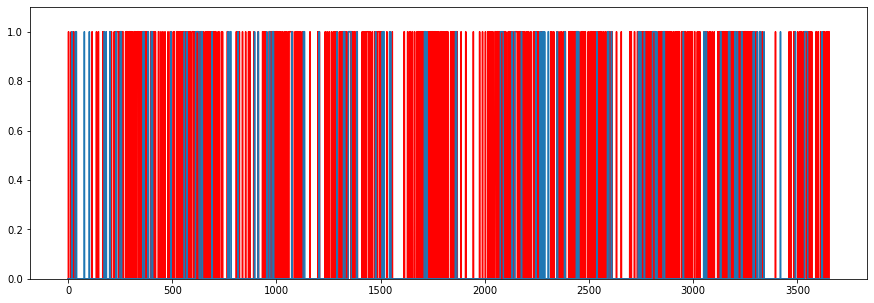

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(cloudstatus, color='r')
plt.plot(telestatus)
plt.ylim(0, 1.1)

In [47]:
(len(times) - len(np.where(cloudstatus)[0]))/10, len(np.where(cloudstatus)[0])/10

(262.0, 103.3)